In [1]:
# As usual, a bit of setup

import time, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from __future__ import print_function
from layers import *
from networks import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

session = None
def get_session():
    global session
    if session is None:
        session = tf.InteractiveSession()
    return session

def initialize_params(params, sess):
    initializable_variables = filter(lambda v: hasattr(v, 'initializer'), params.values())
    if params is not None: sess.run(list(map(lambda v: v.initializer, initializable_variables)))
        

def eval_t(tensor, params=None, feed_dict={}):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        return sess.run(tensor, feed_dict)

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# ResNet 3

To practise working with Tensorflow and neural network architectures, we will now implement the popular ResNet bocks, with skip-connections.

We will follow the proposed (to the right) from the first author of [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf), illustrated by this image:

![Resnet block](https://camo.githubusercontent.com/7ae470c333cd760
78e1c669055ad98bcedaf523f/68747470733a2f2f71696974612d696d6167652d7
3746f72652e73332e616d617a6f6e6177732e636f6d2f302f3130303532332f6131
3536613563322d303236622d646535352d613666622d6534666131373732623432632e706e67)

You will do:
- batch_norm
- relu
- conv2d
- batch_norm
- relu
- conv2d

Finally you add your filtered result to the incomming data.

Implement this in the **resnet_block** in **layers.py**. **resnet_block** takes in a tuple of two filter sizes one for each convolution, and a tuple of two kernel size, one for each convolution. The **stride** parameter should only be used by the first **conv2d**, the other convolution should use **stride=1**.

Since you are using batch_norm it is important to keep track of your update_ops (if your utilizing the is_training variable).

## ResNet 3.1

In this first part, ignore the params 'shortcut/W' and 'shortcut/b' and only use add operation.


In [2]:
#These first line is just to make sure you get the same results every run
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)

#Initialzing variables
loaded = np.load('test_weights/weights_31.npz')
x = tf.convert_to_tensor(loaded['x'], dtype=tf.float32)

#Use your resnet_block function
resnet_out, params, update_op = resnet_block(x, filters=(2, 2))


expected_output = [[[[ 0.93961203, -2.57712746],
                   [-0.44419158, -2.3124783 ],
                   [ 1.68305147,  0.27818435]],

                  [[-0.3723861,  -4.24079657],
                   [-4.86849117,  7.76358986],
                   [-0.84846461, -1.19875765]],

                  [[-0.65678322, -2.80952597],
                   [ 0.98079479,  0.74412948],
                   [-1.67484868, -1.9221983 ]]]]

#Feeding in our own variables for your W and b
feed_dict = {}
for key in ('A/W', 'A/b', 'A/gamma', 'A/beta', 'B/W', 'B/b', 'B/gamma', 'B/beta'):
    feed_dict[params[key]] = loaded[key.replace('/', '_')]

    
output = eval_t(resnet_out, params, feed_dict)
print('Error should be less than 1e-6, and is: %e' % 
      np.abs(output - expected_output).mean())

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Error should be less than 1e-6, and is: 2.990972e+00


## ResNet 3.2 Changing number of channels

If you just add the element-wise the input with the convolved result, you will run into problems if you have changed the number of channels in the filtered result.

This is normally solved by convolving with a 1x1 filter, with the correct number of output channels. If you also change the size, you can use stride in the 1x1 convolution to compansate.

Here you can test your algorithm with changing number of channels.

## Student Comment

This functionality is not working, I get this error:

> ValueError: Filter must not be larger than the input: Filter: (3, 3) Input: (2, 2)

This is either not considered in the assignment or I have a bug in my implementation, which I can not get behind.
I compared to several conv2d implementations (including the one from week 12), but I do not find the problem.
Therefore I will leave this step unsolved.

In [3]:
#These first line is just to make sure you get the same results every run
tf.reset_default_graph(); np.random.seed(1); tf.set_random_seed(1)

#Initialzing variables
loaded = np.load('test_weights/weights_32.npz')
x = tf.convert_to_tensor(loaded['x'], dtype=tf.float32)

#Use your resnet_block function
resnet_out, params, update_op = resnet_block(x, filters=(2, 2), stride=6)

expected_output = [[[[ 1.6043973,  -3.63098097],
                     [ 1.57434261,  2.06497812]],

                    [[-2.62768459, -2.02865243],
                     [-0.96468055,  1.30703235]]]]

#Feeding in our own variables for your W and b
feed_dict = {}
print(params.keys())
for key in ('A/W', 'A/b', 'A/gamma', 'A/beta', 'B/W', 'B/b', 'B/gamma', 'B/beta'):
    feed_dict[params[key]] = loaded[key.replace('/', '_')]
    
output = eval_t(resnet_out, params, feed_dict)
      
assert output.shape == (1, 2, 2, 2), 'Output shape is wrong, are you sure you are \
filtering the shortcut path? Output shape%s' % str(output.shape)

print('Error should be less than 1e-8, and is: %e' % 
      np.abs(output - expected_output).mean())

['A/W', 'A/gamma', 'A/beta', 'A/b', 'shortcut/W', 'B/gamma', 'B/b', 'shortcut/b', 'B/beta', 'B/W']
Instructions for updating:
Use `tf.global_variables_initializer` instead.


ValueError: Cannot feed value of shape (1, 2, 2, 2) for Tensor u'Variable:0', which has shape '(1, 12, 12, 8)'

## ResNet 3.3 Deep residual network

In this last exercise, we will train a network in the same way as we did with **deep_network_with_batchnorm**. Implement the function **deep_residual_network** in **networks**. This functions takes the same input as **deep_network_with_batchnorm** and returns the same output. Instead of using conv2d and batch_norm functions directly you can use the **resnet_block**, but remember that you still have to keep the update_ops.

You can use the same number of filters for both convolutions in a resnet_block, to keep things simple.
With limited number of compute power and network size you may not gain much of an improvement over using just batch normalization.


In [6]:
from cifar import load_cifar
def scale_images(imgs):
    imgs = imgs.astype(np.float32)
    imgs -= imgs.min()
    imgs /= imgs.max()
    return imgs*2 - 1

x_train, y_train = load_cifar()
x_train = scale_images(x_train)
x_test, y_test = load_cifar(test=True)
x_test = scale_images(x_test)

print('Dataset loaded with shapes:', x_train.shape, y_train.shape)
print('Dataset loaded with shapes:', x_test.shape, y_test.shape)

Dataset loaded with shapes: (50000, 32, 32, 3) (50000,)
Dataset loaded with shapes: (10000, 32, 32, 3) (10000,)


[    0/10000] TRAIN loss: 0.65 	 TRAIN accuracy: 0.06
[  100/10000] TRAIN loss: 0.59 	 TRAIN accuracy: 0.36
[  200/10000] TRAIN loss: 0.57 	 TRAIN accuracy: 0.45
[  300/10000] TRAIN loss: 0.57 	 TRAIN accuracy: 0.52
[  400/10000] TRAIN loss: 0.55 	 TRAIN accuracy: 0.47
[  500/10000] TRAIN loss: 0.58 	 TRAIN accuracy: 0.45
[  600/10000] TRAIN loss: 0.58 	 TRAIN accuracy: 0.41
[  700/10000] TRAIN loss: 0.54 	 TRAIN accuracy: 0.52
[  800/10000] TRAIN loss: 0.55 	 TRAIN accuracy: 0.52
[  900/10000] TRAIN loss: 0.53 	 TRAIN accuracy: 0.58
[ 1000/10000] TRAIN loss: 0.56 	 TRAIN accuracy: 0.47
[ 1100/10000] TRAIN loss: 0.52 	 TRAIN accuracy: 0.59
[ 1200/10000] TRAIN loss: 0.53 	 TRAIN accuracy: 0.61
[ 1300/10000] TRAIN loss: 0.57 	 TRAIN accuracy: 0.50
[ 1400/10000] TRAIN loss: 0.52 	 TRAIN accuracy: 0.62
[ 1500/10000] TRAIN loss: 0.53 	 TRAIN accuracy: 0.56
[ 1600/10000] TRAIN loss: 0.51 	 TRAIN accuracy: 0.67
[ 1700/10000] TRAIN loss: 0.53 	 TRAIN accuracy: 0.59
[ 1800/10000] TRAIN loss: 0.

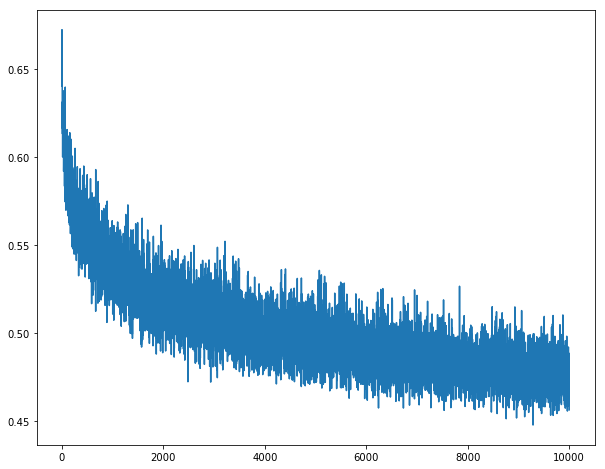

In [9]:
tf.reset_default_graph();

from matplotlib import pyplot as plt

batch_size = 64

x_in = tf.placeholder(tf.float32, [batch_size, 32, 32, 3])
y_in = tf.placeholder(tf.int32, [batch_size])
is_training = tf.placeholder(tf.bool)

number_of_classes = 10

filters=(16, 32, 64, 128) #Change filters to improve your network
strides=(2, 2, 2, 2) #Change stride to improve your network

y = tf.one_hot(y_in, number_of_classes)
logits, loss, params, update_op = deep_residual_network(x_in, y,
                                                   number_of_classes=number_of_classes,
                                                   filters=filters,
                                                   strides=strides,
                                                   is_training=is_training)

with tf.Session() as sess:
    train_loss_history = []
    test_loss_history = []
    ###########################
    #### YOUR CODE HERE #######
    # Write your code for training and testing the network
    is_training_var = tf.Variable(True, dtype=tf.bool)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    init_op = tf.global_variables_initializer()
    sess.run(init_op, {is_training:is_training_var})    
    
    train_iterations = 10000
    for i in range(train_iterations):
        batch_ind = np.random.choice(len(y_train), batch_size)
        x_batch, y_batch = x_train[batch_ind], y_train[batch_ind]        
        loss_val, logit_vals, _, _ = sess.run([loss, logits, train_op, update_op], {x_in:x_batch, 
                                                                                    y_in:y_batch, 
                                                                                    is_training:True})
        train_acc = (logit_vals.argmax(1) == y_batch).mean()
        train_loss_history.append(loss_val)
        
        if i % 100 == 0:
            print('[%5d/%5d] TRAIN loss: %.2f \t TRAIN accuracy: %.2f' % (i, train_iterations, np.mean(loss_val), np.mean(train_acc)))

    # END OF YOUR CODE
    
    #running test and visualization
    np.random.seed(1)
    test_loss = []
    test_acc = []
    for i in range(20):
        batch_ind = np.random.choice(len(y_test), batch_size)
        x_batch, y_batch = x_test[batch_ind], y_test[batch_ind]
        loss_val, logit_vals = sess.run([loss, logits], {x_in:x_batch, y_in:y_batch, is_training:False})
        test_loss.append(loss_val)
        test_acc.append((logit_vals.argmax(1) == y_batch).mean())
    print('TEST loss:', np.mean(test_loss), 'TEST accuracy:', np.mean(test_acc))
    plt.plot(train_loss_history)
    plt.plot(np.linspace(0, len(train_loss_history), len(test_loss_history)), test_loss_history)
    assert np.mean(test_acc)>0.65